# Import Package

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

# Toy Dataset Generation

In [2]:
def generate_toy_datasets(sample_size, is_plot=False, random_state=0):

    print('sample_size', sample_size)

    # ======================== #
    # generate moon shape data #
    # ======================== #
    noise = 0.1
    X_moon, Y_moon = make_moons(n_samples=sample_size,
                                shuffle=True,
                                noise=noise,
                                random_state=random_state)

    if is_plot:
        lab0_idx = (Y_moon == 0)
        lab1_idx = (Y_moon == 1)
        plt.scatter(X_moon[lab0_idx, 0], X_moon[lab0_idx, 1])
        plt.scatter(X_moon[lab1_idx, 0], X_moon[lab1_idx, 1])
        plt.show()

    return X_moon, Y_moon

sample_size 100


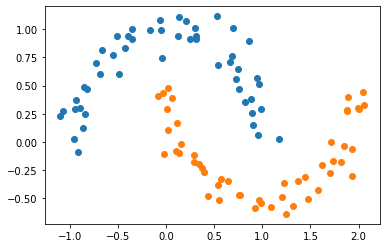

sample_size 500


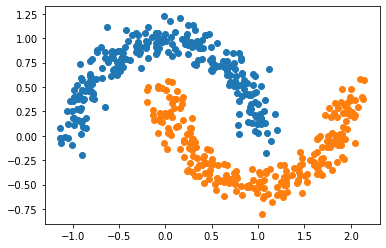

sample_size 1000


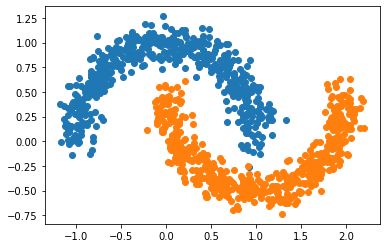

sample_size 5000


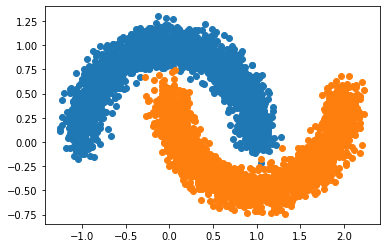

In [3]:
sample_size_list = [100, 500, 1000, 5000]

for sample_size in sample_size_list:
    generate_toy_datasets(sample_size, is_plot=True)

# Openset Sample Enrichment

In [4]:
def open_enrich_demo(target_data,
                     enrich_sample_size,
                     enrich_function,
                     r_seed=0,
                     unknown_ratio=0.9,
                     save_file_target=None,
                     save_file_name_enrich=None):

    sample_enri, sample_coef = enrich_function(r_seed, target_data,
                                               enrich_sample_size)
    theta = np.sort(sample_coef)[int(sample_coef.shape[0] * unknown_ratio)]
    sample_label = np.ones(enrich_sample_size)
    sample_label[np.squeeze(sample_coef < theta)] = -1

    plt.scatter(sample_enri[:, 0], sample_enri[:, 1])
    plt.scatter(target_data[:, 0], target_data[:, 1])
    if save_file_target is not None:
        plt.savefig(save_file_target, bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.scatter(sample_enri[sample_label == -1, 0],
                sample_enri[sample_label == -1, 1])
    plt.scatter(sample_enri[sample_label == 1, 0],
                sample_enri[sample_label == 1, 1])
    if save_file_name_enrich is not None:
        plt.savefig(save_file_name_enrich, bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.hist(sample_coef, bins=500)

    plt.show()
    return sample_enri, sample_coef

## KMM enrichement demo

In [5]:
# ===================================================== #
#                            FYI                        #
# KMM normally performs better than IF                  #
# However, KMM takes too long to process large datasets #
# Therefore, we only demo KMM on toy datasets           #
# ===================================================== #
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
%matplotlib inline
from sklearn.metrics import pairwise_distances


# an implementation of Kernel Mean Matchin
# referenres:
#  1. Gretton, Arthur, et al. "Covariate shift by kernel mean matching." Dataset shift in machine learning 3.4 (2009): 5.
#  2. Huang, Jiayuan, et al. "Correcting sample selection bias by unlabeled data." Advances in neural information processing systems. 2006.
def kernel_mean_matching(X, Z, kern='lin', B=1.0, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B / math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T) * float(nz) / float(nx), axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z, Z)
        kappa = np.sum(compute_rbf(Z, X), axis=1) * float(nz) / float(nx)
    else:
        raise ValueError('unknown kernel')

    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1, nz)), -np.ones(
        (1, nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz * (1 + eps), nz * (eps - 1), B * np.ones(
        (nz, )
    ), np.zeros((nz, ))])

    solvers.options['show_progress'] = True
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef


def compute_rbf(X, Z):
    sigma = np.median(pairwise_distances(X).std())
    print(sigma)
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i, :] = np.exp(-np.sum((vx - Z)**2, axis=1) / (2.0 * sigma))
    return K


def sample_enrichment_kmm(r_seed, target_data, sample_size):
    np.random.seed(r_seed)
    domain_max = target_data.max(axis=0)
    domain_min = target_data.min(axis=0)
    domain_dim = target_data.shape[1]

    sample_enri = np.random.random(size=(sample_size, domain_dim))

    domain_gap = (domain_max - domain_min) * 1.2
    domain_mean = (domain_max + domain_min) / 2

    for dim_idx in range(domain_dim):
        sample_enri[:, dim_idx] = sample_enri[:, dim_idx] * domain_gap[
            dim_idx] + domain_mean[dim_idx] - domain_gap[dim_idx] / 2

    sample_coef = kernel_mean_matching(target_data,
                                       sample_enri,
                                       kern='rbf',
                                       B=50)
    return sample_enri, np.squeeze(sample_coef)

sample_size 1000
0.8930109757675644
0.8930109757675644
     pcost       dcost       gap    pres   dres
 0: -2.3692e+05 -7.8164e+07  8e+07  2e-02  1e-14
 1:  1.0188e+05 -5.3413e+06  5e+06  2e-04  3e-15
 2: -2.0511e+05 -4.7485e+06  5e+06  1e-15  8e-15
 3: -2.1328e+05 -5.2589e+05  3e+05  2e-16  2e-15
 4: -2.3138e+05 -3.0091e+05  7e+04  4e-16  2e-16
 5: -2.3557e+05 -2.5009e+05  1e+04  7e-16  2e-16
 6: -2.3672e+05 -2.4196e+05  5e+03  2e-16  2e-16
 7: -2.3694e+05 -2.3816e+05  1e+03  4e-16  2e-16
 8: -2.3698e+05 -2.3805e+05  1e+03  3e-16  2e-16
 9: -2.3704e+05 -2.3726e+05  2e+02  8e-16  2e-16
10: -2.3705e+05 -2.3724e+05  2e+02  6e-16  2e-16
11: -2.3706e+05 -2.3715e+05  9e+01  5e-16  2e-16
12: -2.3707e+05 -2.3709e+05  2e+01  2e-16  2e-16
13: -2.3707e+05 -2.3708e+05  6e+00  2e-16  2e-16
14: -2.3707e+05 -2.3707e+05  3e+00  1e-16  2e-16
15: -2.3707e+05 -2.3707e+05  7e-01  3e-16  2e-16
16: -2.3707e+05 -2.3707e+05  5e-01  4e-16  2e-16
17: -2.3707e+05 -2.3707e+05  1e-01  3e-16  2e-16
Optimal solutio

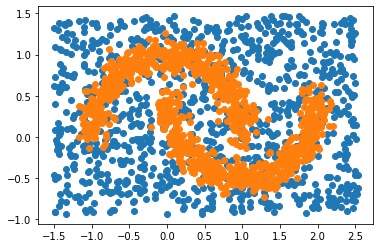

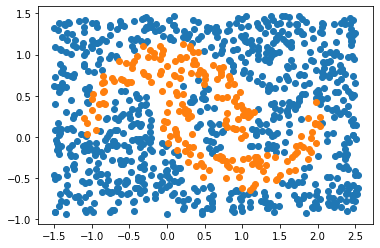

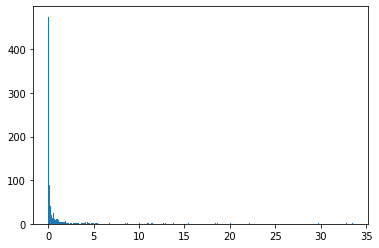

In [6]:
X_moon, Y_moon = generate_toy_datasets(1000)

_, _ = open_enrich_demo(X_moon,
                        1000,
                        sample_enrichment_kmm,
                        unknown_ratio=0.8,
                        save_file_target='moon_tar_kmm.pdf',
                        save_file_name_enrich='moon_enr_kmm.pdf')

## Outlier enrichement Demo

In [7]:
from sklearn.ensemble import IsolationForest

def sample_enrichment_IF(r_seed, target_data, sample_size):
    np.random.seed(r_seed)
    domain_max = target_data.max(axis=0)
    domain_min = target_data.min(axis=0)
    domain_dim = target_data.shape[1]

    sample_enri = np.random.random(size=(sample_size, domain_dim))
    
    domain_gap = (domain_max - domain_min) * 1.2
    domain_mean = (domain_max + domain_min) / 2
    
    for dim_idx in range(domain_dim):
        sample_enri[:, dim_idx] = sample_enri[:, dim_idx] * domain_gap[
            dim_idx] + domain_mean[dim_idx] - domain_gap[dim_idx] / 2
    
    clf = IsolationForest(random_state=r_seed, max_samples=0.9).fit(target_data)
    sample_coef = clf.score_samples(sample_enri)
    sample_coef -= sample_coef.min()
    sample_coef /= sample_coef.max()
    print(np.unique(sample_coef).shape)
    return sample_enri, np.squeeze(sample_coef)

sample_size 1000


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(939,)


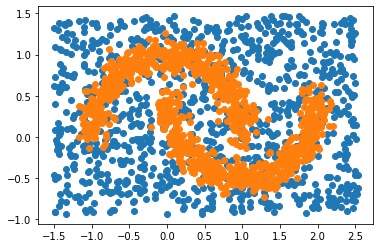

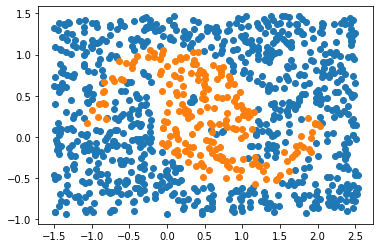

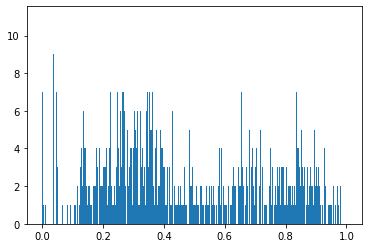

In [8]:
X_moon, Y_moon = generate_toy_datasets(1000)

_, _ = open_enrich_demo(X_moon,
                        1000,
                        sample_enrichment_IF,
                        unknown_ratio=0.8,
                        save_file_target='moon_tar_IF.pdf',
                        save_file_name_enrich='moon_enr_IF.pdf')

# Openset Learning

In [9]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [10]:
class pq_risk(tf.keras.losses.Loss):
    
    def __init__(self, model, x_q, x_w, z_p_X, outlier_ratio, k):
        super().__init__(name='pq_risk')
        self.model = model
        self.x_q = x_q
        self.x_w = x_w
        self.k = k
        self.z_p_X = z_p_X
        self.outlier_ratio = outlier_ratio
 
    def call(self, y_true, y_pred):
        
        Rs_all_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        
        y_t_pred = self.model(self.x_q)
        y_true_q = np.zeros(self.x_w.shape[0]) + self.k
        Rt_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true_q, y_t_pred)
        Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.x_w, dtype=tf.float32), Rt_k_hat)
        Rt_k_hat = tf.reduce_mean(Rt_k_hat)

        num_out = tf.math.argmax(self.model(self.z_p_X), axis=1)
        num_out = tf.reduce_sum(tf.cast(tf.equal(num_out, self.k), tf.int32))     
        num_out = tf.cast(num_out, tf.float32 )
        num_out = tf.stop_gradient(num_out)
        
        outlier = self.z_p_X.shape[0] * self.outlier_ratio
        
        if num_out == 0:
            num_out = 0.0001
        
        return Rs_all_hat + (outlier*1.0/(num_out*1.0))* Rt_k_hat

In [11]:
X_moon, Y_moon = generate_toy_datasets(10000)

sample_size 10000


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(12529,)
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5096 - accuracy: 0.8463
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9984
Epoch 3/5
313/313 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9983
Epoch 4/5
313/313 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9957
Epoch 5/5
313/313 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9982


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(938,)


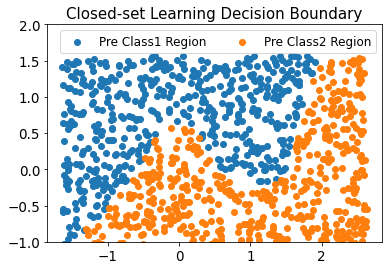

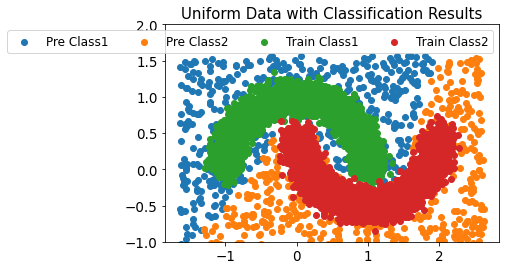

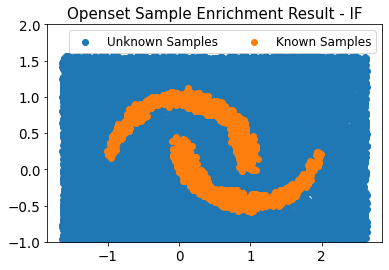

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 43803828.8854 - accuracy: 0.4323
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.2858 - accuracy: 0.3178
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.1287 - accuracy: 0.6002
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8856 - accuracy: 0.7006
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.7819 - accuracy: 0.7906
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6803 - accuracy: 0.8818
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6559 - accuracy: 0.9258
Epoch 8/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5516 - accuracy: 0.9351
Epoch 9/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5171 - accuracy: 0.9374
Epoch 10/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5047 - accuracy:

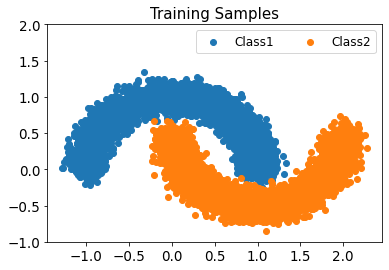

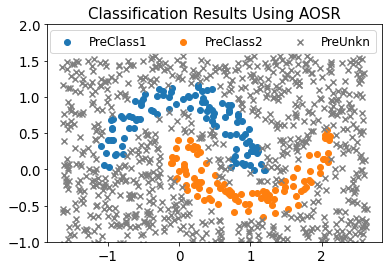

In [13]:
z_p_X = X_moon
z_p_Y = Y_moon

z_q_sample, z_q_weight = sample_enrichment_IF(0, z_p_X, 15000)
z_q_weight = 1 - z_q_weight * 1.0

tau = np.sort(z_q_weight)[int(z_q_weight.shape[0] * .1)]
cond1 = (z_q_weight > tau)
cond1 = np.squeeze(cond1)
cond2 = (z_q_weight <= tau)
cond2 = np.squeeze(cond2)

z_q_weight[cond2] = 0
z_q_weight = z_q_weight * (z_q_weight.shape[0] / z_q_weight.sum())

tf.random.set_seed(0)
detetor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation(activation='softmax')
])

detetor.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
K.set_value(detetor.optimizer.learning_rate, 0.001)
detetor.fit(z_p_X, z_p_Y * 1.0, epochs=5)


sample_test, _ = sample_enrichment_IF(0, z_p_X, 1000)
y_pred = detetor.predict(sample_test)
y_pred_lab = y_pred.argmax(axis=1)

plt.scatter(sample_test[y_pred_lab==0,0], sample_test[y_pred_lab==0,1])
plt.scatter(sample_test[y_pred_lab==1,0], sample_test[y_pred_lab==1,1])
plt.ylim([-1, 2])
plt.yticks(fontsize=13.5)
plt.xticks(fontsize=13.5)
plt.title('Closed-set Learning Decision Boundary', fontsize=15)
plt.legend(['Pre Class1 Region', 'Pre Class2 Region'], ncol=2, fontsize=12)
plt.savefig("moon_closeset_pred.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

plt.scatter(sample_test[y_pred_lab==0,0], sample_test[y_pred_lab==0,1])
plt.scatter(sample_test[y_pred_lab==1,0], sample_test[y_pred_lab==1,1])
plt.scatter(z_p_X[z_p_Y==0,0], z_p_X[z_p_Y==0,1])
plt.scatter(z_p_X[z_p_Y==1,0], z_p_X[z_p_Y==1,1])
plt.ylim([-1, 2])
plt.yticks(fontsize=13.5)
plt.xticks(fontsize=13.5)
plt.title('Uniform Data with Classification Results', fontsize=15)
plt.legend(['Pre Class1', 'Pre Class2', 'Train Class1', 'Train Class2'], ncol=4, fontsize=12)
plt.savefig("moon_closeset_pred_with_train.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

plt.scatter(z_q_sample[z_q_weight!=0,0], z_q_sample[z_q_weight!=0,1])
plt.scatter(z_q_sample[z_q_weight==0,0], z_q_sample[z_q_weight==0,1])
plt.ylim([-1, 2])
plt.yticks(fontsize=13.5)
plt.xticks(fontsize=13.5)
plt.title('Openset Sample Enrichment Result - IF', fontsize=15)
plt.legend(['Unknown Samples', 'Known Samples'], ncol=3, fontsize=12)
plt.savefig("moon_enrich_if.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

detetor.compile(optimizer='adam',
                loss=pq_risk(detetor, z_q_sample, z_q_weight, z_p_X, 0.15, 2),
                metrics=['accuracy'])

K.set_value(detetor.optimizer.learning_rate, 0.001)
detetor.fit(z_p_X, z_p_Y * 1.0, epochs=20)
K.set_value(detetor.optimizer.learning_rate, 0.0001)
detetor.fit(z_p_X, z_p_Y * 1.0, epochs=10)

y_pred = detetor.predict(sample_test)
y_pred_lab = y_pred.argmax(axis=1)

plt.scatter(z_p_X[z_p_Y==0,0], z_p_X[z_p_Y==0,1])
plt.scatter(z_p_X[z_p_Y==1,0], z_p_X[z_p_Y==1,1])
plt.ylim([-1, 2])
plt.yticks(fontsize=13.5)
plt.xticks(fontsize=13.5)
plt.title('Training Samples', fontsize=15)
plt.legend(['Class1', 'Class2'], ncol=2, fontsize=12)
plt.savefig("moon_train_data.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

plt.scatter(sample_test[y_pred_lab==0,0], sample_test[y_pred_lab==0,1])
plt.scatter(sample_test[y_pred_lab==1,0], sample_test[y_pred_lab==1,1])
plt.scatter(sample_test[y_pred_lab==2,0], sample_test[y_pred_lab==2,1], c='grey', marker='x')
plt.ylim([-1, 2])
plt.yticks(fontsize=13.5)
plt.xticks(fontsize=13.5)
plt.title('Classification Results Using AOSR', fontsize=15)
plt.legend(['PreClass1', 'PreClass2', 'PreUnkn'], ncol=3, fontsize=12)
plt.savefig("moon_openset_pred.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()